In [1]:
# ! pip install gym
# ! pip install gym stable-baselines3 torch
# ! pip install 'shimmy>=0.2.1'
# !pip install pygame 

In [51]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

import torch
import pygame
import random

import gym
from gym import spaces
from gym.utils import seeding

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv
import torch  
import torch.nn as nn 
import torch.optim as optim  
import torch.nn.functional as F 

from collections import deque, namedtuple
from itertools import count
from PIL import Image

In [7]:
# Define constants
WIDTH = 800
HEIGHT = 600
PADDLE_WIDTH = 100
PADDLE_HEIGHT = 20
PUCK_RADIUS = 10
PADDLE_SPEED = 5
PUCK_SPEED = 5
BACKGROUND_COLOR = (0, 0, 0)  # Black
PADDLE_COLOR_1 = (0, 255, 255)  # Cyan for player 1
PADDLE_COLOR_2 = (255, 0, 255)  # Magenta for player 2
PUCK_COLOR = (255, 255, 255)  # White for puck
SCORE_COLOR = (255, 255, 255)  # White for score text
FONT_SIZE = 48 
FPS = 60  # Frames per second

In [8]:
class Paddle:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.width = PADDLE_WIDTH
        self.height = PADDLE_HEIGHT

    def move_left(self):
        self.x -= PADDLE_SPEED
        if self.x < 0:
            self.x = 0

    def move_right(self):
        self.x += PADDLE_SPEED
        if self.x + self.width > WIDTH:
            self.x = WIDTH - self.width

class Puck:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.radius = PUCK_RADIUS
        self.dx = random.choice([-1, 1]) * PUCK_SPEED
        self.dy = random.choice([-1, 1]) * PUCK_SPEED

    def update(self):
        self.x += self.dx
        self.y += self.dy

        if self.x - self.radius <= 0 or self.x + self.radius >= WIDTH:
            self.dx *= -1
        if self.y - self.radius <= 0 or self.y + self.radius >= HEIGHT:
            self.dy *= -1

class Goal:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def check_goal(self, puck):
        if self.y <= puck.y - puck.radius <= self.y + self.height and \
                self.x - self.width // 2 <= puck.x <= self.x + self.width // 2:
            return 1  # Player 1 scored
        elif self.y + self.height >= puck.y + puck.radius >= self.y and \
                self.x - self.width // 2 <= puck.x <= self.x + self.width // 2:
            return 2  # Player 2 scored
        else:
            return 0  # No goal

In [9]:
class AirHockeyEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, config):
        super(AirHockeyEnv, self).__init__()
        self.action_space = spaces.Tuple((spaces.Discrete(3), spaces.Discrete(3)))  # Actions for both paddles
        self.observation_space = spaces.Box(low=0, high=255, shape=(HEIGHT, WIDTH, 3), dtype=np.uint8)
        
        # Initialize paddles and puck
        self.paddle1 = Paddle(WIDTH // 2 - PADDLE_WIDTH // 2, HEIGHT - 2 * PADDLE_HEIGHT)
        self.paddle2 = Paddle(WIDTH // 2 - PADDLE_WIDTH // 2, PADDLE_HEIGHT)
        self.puck = Puck(WIDTH // 2, HEIGHT // 2)
        self.goal = Goal(WIDTH // 2 - 50, 0, 100, 20)  # Assuming the goal width is 100 and height is 20
        self.score = [0, 0]
        self.game_count = 0

        self.background_image = pygame.image.load('AirHockeyBackground.jpeg')
        self.paddle_green_image = pygame.image.load('PuckGreen.jpeg')
        self.paddle_red_image = pygame.image.load('PuckRed.jpeg')
        self.puck_image = pygame.image.load('Puck.jpeg')
        self.max_games = config['max_games']
        self.timestamps_per_game = config['timestamps_per_game']
        self.clock = pygame.time.Clock()

        pygame.init()
        self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
        pygame.display.set_caption("Multi-Agent Air Hockey")
        self.clock = pygame.time.Clock()

    def seed(self, seed=None):
        self.seed_value = seed
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        # Reset positions
        self.paddle1.x = WIDTH // 2 - PADDLE_WIDTH // 2
        self.paddle1.y = HEIGHT - 2 * PADDLE_HEIGHT
        self.paddle2.x = WIDTH // 2 - PADDLE_WIDTH // 2
        self.paddle2.y = PADDLE_HEIGHT
        self.puck.x = WIDTH // 2
        self.puck.y = HEIGHT // 2
        self.score = [0, 0]
        self.game_count = 0
        self.timer = self.timestamps_per_game
        return self._get_observation()

    def step(self, action):
        reward = [0, 0]  # Initialize rewards for both agents
        done = False
        info = {}

        self._take_action(action)
        self.puck.update()
        collision = self._check_collision()
        if collision == 1:
            reward[0] += 2  # Agent 1 hits the puck
        elif collision == 2:
            reward[1] += 2  # Agent 2 hits the puck

        goal_scored = self.goal.check_goal(self.puck)
        if goal_scored:
            scorer = goal_scored - 1  # Adjusting for 0-index
            reward[scorer] += 10
            self.score[scorer] += 1
            done = True  # End the episode when a goal is scored

        self.timer -= 1
        if self.timer <= 0 or self.game_count >= self.max_games:
            done = True

        return self._get_observation(), reward, done, info

    def _take_action(self, action):
        if action[0] == 1:
            self.paddle1.move_left()
        elif action[0] == 2:
            self.paddle1.move_right()
        if action[1] == 1:
            self.paddle2.move_left()
        elif action[1] == 2:
            self.paddle2.move_right()


    def _check_collision(self):
        # Check if the puck collides with paddle1
        if self.puck.x + self.puck.radius > self.paddle1.x and \
           self.puck.x - self.puck.radius < self.paddle1.x + PADDLE_WIDTH and \
           self.puck.y + self.puck.radius > self.paddle1.y and \
           self.puck.y - self.puck.radius < self.paddle1.y + PADDLE_HEIGHT:
            return 1  # Puck collides with paddle1
    
        # Check if the puck collides with paddle2
        if self.puck.x + self.puck.radius > self.paddle2.x and \
           self.puck.x - self.puck.radius < self.paddle2.x + PADDLE_WIDTH and \
           self.puck.y + self.puck.radius > self.paddle2.y and \
           self.puck.y - self.puck.radius < self.paddle2.y + PADDLE_HEIGHT:
            return 2  # Puck collides with paddle2
    
        return 0  # No collision


    def _get_observation(self):
        # Here, we'll return a simplified state vector.
        state = np.array([self.paddle1.x, self.paddle1.y, self.paddle2.x, self.paddle2.y, self.puck.x, self.puck.y])
        return state

    def render(self, mode='human'):
        if mode != 'human':
            raise NotImplementedError("Render mode not supported: {}".format(mode))

        # Ensure the screen is initialized
        if not hasattr(self, 'screen') or self.screen is None:
            raise RuntimeError("Rendering not set up - call initialization method first.")

        # Blit the background image
        self.screen.blit(self.background_image, (0, 0))

        # Draw the paddles as rectangles
        pygame.draw.rect(self.screen, PADDLE_COLOR_1, (self.paddle1.x, self.paddle1.y, PADDLE_WIDTH, PADDLE_HEIGHT))
        pygame.draw.rect(self.screen, PADDLE_COLOR_2, (self.paddle2.x, self.paddle2.y, PADDLE_WIDTH, PADDLE_HEIGHT))

        # Draw the puck as a circle
        pygame.draw.circle(self.screen, PUCK_COLOR, (self.puck.x, self.puck.y), self.puck.radius)

        # Render the score
        font = pygame.font.Font(None, FONT_SIZE)
        score_text_p1 = font.render(str(self.score[0]), True, SCORE_COLOR)
        score_text_p2 = font.render(str(self.score[1]), True, SCORE_COLOR)

        # Position the score text on the screen
        self.screen.blit(score_text_p1, (WIDTH * 0.25, 10))  # Adjust positions as necessary
        self.screen.blit(score_text_p2, (WIDTH * 0.75, 10))  # Adjust positions as necessary

        # Update the display
        pygame.display.flip()

        # Control the game speed
        self.clock.tick(60)

        # Check for quit event
        should_quit = False
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                should_quit = True

        if should_quit:
            self.close()

    def close(self):
        pygame.quit()

In [5]:
# def evaluate_random_agents(env, num_episodes=10):
#     scores_player1 = []
#     scores_player2 = []

#     for episode in range(num_episodes):
#         obs = env.reset()
#         done = False
#         score_player1 = 0
#         score_player2 = 0

#         while not done:
#             # Handle events to prevent window from hanging
#             for event in pygame.event.get():
#                 if event.type == pygame.QUIT:
#                     done = True  # Ensure done is set to exit the loop
            
#             if done:
#                 break  # Exit the loop if done is set to True

#             # Random actions for each player
#             env.render()
#             action1 = env.action_space.sample()[0]  # Random action for player 1
#             action2 = env.action_space.sample()[1]  # Random action for player 2
#             action = (action1, action2)
            
#             obs, rewards, done, _ = env.step(action)
#             score_player1 += rewards[0]
#             score_player2 += rewards[1]

#         # Close the environment if the QUIT event is caught
#         if done:
#             env.close()
#             break

#         scores_player1.append(score_player1)
#         scores_player2.append(score_player2)
#         print(f"Episode {episode+1} - Player 1 Score: {score_player1}, Player 2 Score: {score_player2}")

#     if not done:
#         # Determine the final winner based on total scores
#         winner = "Player 1" if sum(scores_player1) > sum(scores_player2) else "Player 2" if sum(scores_player1) < sum(scores_player2) else "Tie"
#         print("Final Winner:", winner)
#         env.close()

#     return scores_player1, scores_player2


In [6]:
# # Initialize the Air Hockey environment with your config here
# config = {
#     'max_games': 10,  # Example configuration
#     'timestamps_per_game': 1200,  # Example configuration
# }
# env = AirHockeyEnv(config)

# # Evaluate the environment with random agents
# scores_player1, scores_player2 = evaluate_random_agents(env, num_episodes=10)

In [26]:
class DoubleQLearningAgent:
    def __init__(self, action_space, lr, discount, min_epsilon, max_epsilon, epsilon_decay):
        self.action_space = action_space
        self.q1_table = {}
        self.q2_table = {}
        self.lr =  lr
        self.discount = discount
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon = max_epsilon

    def get_q_values(self, q_table, state, action=None):
        if state not in q_table:
            q_table[state] = np.zeros(len(self.action_space))
        if action is None:
            return q_table[state]
        return q_table[state][action]

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.action_space)
        else:
            # Estimate the action value by averaging the two Q-tables
            avg_q = (self.get_q_values(self.q_table_a, state) + self.get_q_values(self.q_table_b, state)) / 2
            return np.argmax(avg_q)

    def learn(self, state, action, reward, next_state, done):
        if random.uniform(0, 1) < 0.5:
            next_action = np.argmax(self.get_q_values(self.q_table_a, next_state))
            td_target = reward + self.gamma * self.get_q_values(self.q_table_b, next_state, next_action) * (not done)
            td_error = td_target - self.get_q_values(self.q_table_a, state, action)
            self.q_table_a[state][action] += self.lr * td_error
        else:
            q2_next = self.q2_table[next_obs_tuple]
            best_next_action = np.argmax(q2_next)
            q2_value = self.q2_table[obs_tuple][action]
            q1_value = reward + self.discount * q2_next[best_next_action] * (not done)
            self.q2_table[obs_tuple][action] = (1 - self.lr) * q2_value + self.lr * q1_value




In [27]:
def evaluate_double_q_learning_agents(env, agent1, agent2, num_episodes=100, render=False):
    scores_player1 = []  # To accumulate scores for each episode for Player 1
    scores_player2 = []  # To accumulate scores for each episode for Player 2
    
    for episode in range(num_episodes):
        state = env.reset()
        score_player1 = 0  # Initialize score for Player 1 for the episode
        score_player2 = 0  # Initialize score for Player 2 for the episode
        done = False
        
        while not done:
            # env.render()
            # Choose actions for each player based on Q-values
            action1 = agent1.choose_action(obs)
            action2 = agent2.choose_action(obs)
            next_obs, rewards, done, _ = env.step((action1, action2))
            agent1.update_q_values(obs, action1, rewards[0], next_obs, done)
            agent2.update_q_values(obs, action2, rewards[1], next_obs, done)
            obs = next_obs
            score_player1 += rewards[0]
            score_player2 += rewards[1]

        scores_player1.append(score_player1)
        scores_player2.append(score_player2)
        print(f"Episode {episode+1} - Player 1 Score: {score_player1}, Player 2 Score: {score_player2}")

    # Determine the final winner based on total scores
    winner = "Player 1" if sum(scores_player1) > sum(scores_player2) else "Player 2" if sum(scores_player1) < sum(scores_player2) else "Tie"
    print("Final Winner:", winner)

    # Calculate and print the average score for each player
    average_score_player1 = np.mean(scores_player1)
    average_score_player2 = np.mean(scores_player2)
    print(f"Average score for Player 1: {average_score_player1}")
    print(f"Average score for Player 2: {average_score_player2}")

# Assuming env, agent1, and agent2 are already defined and initialized
# evaluate_double_q_learning_agents(env, agent1, agent2, num_episodes=100, render=False)

In [71]:
def train_double_q_agents(env, agent1, agent2, num_episodes):

    agent1_rewards = []
    agent2_rewards = []

    for episode in range(num_episodes):
        # Reset the environment and get the initial observation
        obs = env.reset()
        done = False
        total_reward = [0, 0]  # Total reward for each agent

        while not done:
            # Agents choose actions based on their current policy
            action1 = agent1.choose_action(obs)
            action2 = agent2.choose_action(obs)

            # Execute actions in the environment and observe the results
            next_obs, rewards, done, info = env.step((action1, action2))

            # Update Q-tables for both agents
            agent1.update_q_values(obs, action1, rewards[0], next_obs, done)
            agent2.update_q_values(obs, action2, rewards[1], next_obs, done)

            # Update total rewards and observation
            total_reward[0] += rewards[0]
            total_reward[1] += rewards[1]

            obs = next_obs
            
        agent1_rewards.append(total_reward[0])
        agent2_rewards.append(total_reward[1])

        # Decaying the exploration rate
        agent1.epsilon = max(agent1.min_epsilon, agent1.epsilon * agent1.epsilon_decay)
        agent2.epsilon = max(agent2.min_epsilon, agent2.epsilon * agent2.epsilon_decay)

        # Logging the results at certain intervals
        if episode % 100 == 0 or episode == num_episodes - 1:
            print(f"Episode {episode + 1}/{num_episodes} | " 
                  f"Player 1 Total Reward: {total_reward[0]} | "
                  f"Player 2 Total Reward: {total_reward[1]} | "
                  f"Epsilon: {agent1.epsilon:.4f}")
            

    return agent1_rewards, agent2_rewards

# Parameters
lr = 0.001
discount = 0.97
min_epsilon = 0.01
max_epsilon = 1
num_episodes = 10000
epsilon_decay = (min_epsilon / max_epsilon) ** (1 / num_episodes)

# Environment and agent initialization
config = {
    'max_games': 10,  # Example configuration
    'timestamps_per_game': 1200,  # Example configuration
}

# Create the environment
env = AirHockeyEnv(config)

# Initialize the agents
agent1 = DoubleQLearningAgent(env.action_space[0], lr, discount, min_epsilon, max_epsilon, epsilon_decay)
agent2 = DoubleQLearningAgent(env.action_space[1], lr, discount, min_epsilon, max_epsilon, epsilon_decay)

# Start training
agent1_rewards, agent2_rewards = train_double_q_agents(env, agent1, agent2, num_episodes)

Episode 1/10000 | Player 1 Total Reward: 48 | Player 2 Total Reward: 0 | Epsilon: 0.9995
Episode 101/10000 | Player 1 Total Reward: 16 | Player 2 Total Reward: 0 | Epsilon: 0.9546
Episode 201/10000 | Player 1 Total Reward: 26 | Player 2 Total Reward: 10 | Epsilon: 0.9116
Episode 301/10000 | Player 1 Total Reward: 28 | Player 2 Total Reward: 0 | Epsilon: 0.8706
Episode 401/10000 | Player 1 Total Reward: 28 | Player 2 Total Reward: 0 | Epsilon: 0.8314
Episode 501/10000 | Player 1 Total Reward: 16 | Player 2 Total Reward: 0 | Epsilon: 0.7940
Episode 601/10000 | Player 1 Total Reward: 0 | Player 2 Total Reward: 0 | Epsilon: 0.7582
Episode 701/10000 | Player 1 Total Reward: 52 | Player 2 Total Reward: 18 | Epsilon: 0.7241
Episode 801/10000 | Player 1 Total Reward: 16 | Player 2 Total Reward: 0 | Epsilon: 0.6915
Episode 901/10000 | Player 1 Total Reward: 32 | Player 2 Total Reward: 0 | Epsilon: 0.6604
Episode 1001/10000 | Player 1 Total Reward: 50 | Player 2 Total Reward: 18 | Epsilon: 0.630

In [72]:
print(f'Agent 1 Rewards: {sum(agent1_rewards)}')
print(f'Agent 2 Rewards: {sum(agent2_rewards)}')

Agent 1 Rewards: 364602
Agent 2 Rewards: 52756


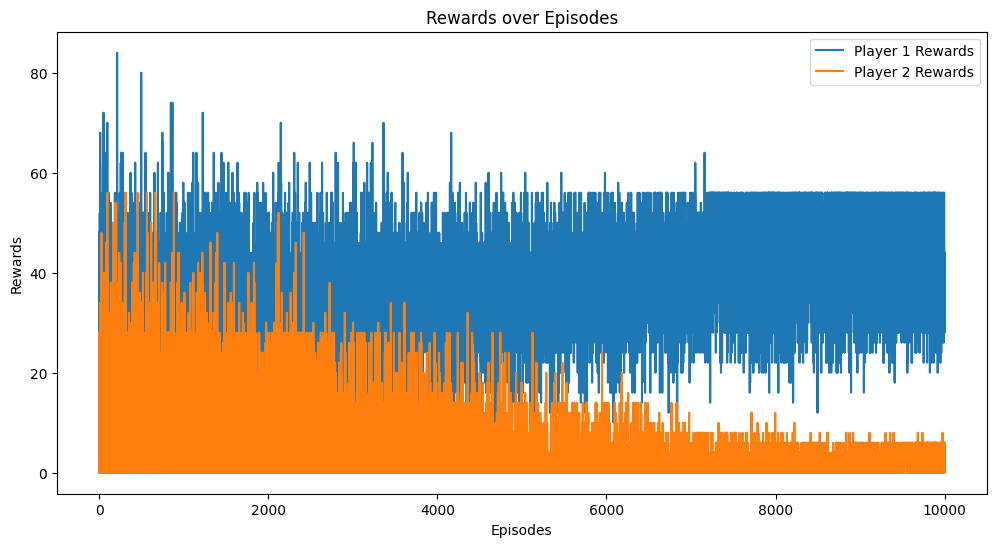

In [73]:
# Plottiing the rewards
plt.figure(figsize=(12, 6))
plt.plot(agent1_rewards, label='Player 1 Rewards')
plt.plot(agent2_rewards, label='Player 2 Rewards')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards over Episodes')
plt.legend()
plt.show()


In [19]:
lr = 0.001
discount = 0.99
min_epsilon = 0.01
max_epsilon = 1
num_episodes = 1000
epsilon_decay = (min_epsilon/max_epsilon) ** (1/num_episodes)

# Initialize the Air Hockey environment with your config here
config = {
    'max_games': 10,  # Example configuration
    'timestamps_per_game': 1200,  # Example configuration
}
env = AirHockeyEnv(config)

# Assuming the environment has a discrete action space
agent1 = DoubleQLearningAgent(env.action_space[0], lr=lr, discount=discount, min_epsilon=min_epsilon, max_epsilon=max_epsilon, epsilon_decay=epsilon_decay)
agent2 = DoubleQLearningAgent(env.action_space[1], lr=lr, discount=discount, min_epsilon=min_epsilon, max_epsilon=max_epsilon, epsilon_decay=epsilon_decay)

scores_player1, scores_player2 = evaluate_double_q_learning_agents(env, agent1, agent2, 10)

Episode 1 - Player 1 Score: 10, Player 2 Score: 0
Episode 2 - Player 1 Score: 10, Player 2 Score: 8
Episode 3 - Player 1 Score: 8, Player 2 Score: 32
Episode 4 - Player 1 Score: 22, Player 2 Score: 8
Episode 5 - Player 1 Score: 24, Player 2 Score: 8
Episode 6 - Player 1 Score: 20, Player 2 Score: 20
Episode 7 - Player 1 Score: 46, Player 2 Score: 0
Episode 8 - Player 1 Score: 14, Player 2 Score: 24
Episode 9 - Player 1 Score: 34, Player 2 Score: 0
Episode 10 - Player 1 Score: 20, Player 2 Score: 14
Final Winner: Player 1


In [20]:
# Calculate and print the average score for each player
average_score_player1 = np.mean(scores_player1)
average_score_player2 = np.mean(scores_player2)
print("Average score for Player 1:", average_score_player1)
print("Average score for Player 2:", average_score_player2)

Average score for Player 1: 20.8
Average score for Player 2: 11.4


In [14]:
# Close the evaluation environment
env.close()

In [69]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)  # Reduced from 128 to 64
        self.fc2 = nn.Linear(64, 64)   # Simplified architecture
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, int(done)))


    def sample(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        
        states, actions, rewards, next_states, dones = zip(*samples)
  
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.long).view(-1, 1)
        rewards = torch.tensor(rewards, dtype=torch.float).view(-1, 1)
        next_states = torch.tensor(next_states, dtype=torch.float)
        dones = torch.tensor(dones, dtype=torch.float).view(-1, 1)

        return states, actions, rewards, next_states, dones


    def __len__(self):
        return len(self.memory)


class DQNAgent():
    def __init__(self,env,state_space, action_space, max_epsilon,min_epsilon,learning_rate,discount_factor,buffer_size,batch_size,update_frequency, epsilon_decay, env_name):
        self.env = env
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.state_size = state_space.shape[0]
        
        if isinstance(action_space, gym.spaces.Discrete):
            self.action_size = action_space.n
        elif isinstance(action_space, gym.spaces.Box):
            self.action_size = action_space.shape[0]  # Assuming you want to handle Box action spaces
        else:
            raise NotImplementedError("Action space type not supported")
        
        self.epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.buffer = ReplayBuffer(buffer_size)
        self.policy_net = DQN(self.state_size, self.action_size).to(self.device)
        self.target_net = DQN(self.state_size, self.action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.steps_done = 0
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.update_frequency = update_frequency
        self.env_name = env_name
    
    def select_action(self,state, epsilon):
        if random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.tensor([state], dtype=torch.float).to(self.device)
                action = self.policy_net(state).max(1)[1].view(1, 1).item()
                return action
    
    def select_greedy_action(self,state):
        with torch.no_grad():
            return self.policy_net(state).max(1)[1].view(1, 1).item()
    
    def optimize_model(self):
        if len(self.buffer) > self.batch_size:
           
            transitions = self.buffer.sample(self.batch_size)
            states, actions, rewards, next_states, dones = transitions
            states  = states.to(self.device)
            actions = actions.to(self.device)
            rewards = rewards.to(self.device)
            next_states = next_states.to(self.device)
            dones = dones.to(self.device)

            q_values = self.policy_net(states).gather(1, actions)
            expected_q_values = self.target_net(next_states).max(1)[0].detach()
            expected_state_action_values = (expected_q_values.unsqueeze(1) * (1 - dones) * self.discount_factor) + rewards

            loss = F.mse_loss(q_values, expected_state_action_values)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def sync_networks(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    
    def train(self,episodes):
        # Initialize lists to store metrics for each episode
        self.episode_rewards = []
        self.episode_epsilons = []
     

        for episode in range(episodes):
            state ,_ = self.env.reset()

            total_reward = 0
            done = False

            while not done:

                self.steps_done += 1
                action = self.select_action(state, self.epsilon)
                next_state, reward, terminated,truncated ,_  = self.env.step(action) 
                done = terminated or truncated
             
                total_reward += reward
                
                self.buffer.push(state, action, reward, next_state, done)
                state = next_state
                
                self.optimize_model()
            
                # if episode % self.update_frequency == 0:
                if self.steps_done % self.update_frequency == 0:
                    self.sync_networks()
                
            if episode % 100 == 0:   
                print(f'Episode: {episode} total_reward: {total_reward} epsilon: {self.epsilon}')
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            self.episode_rewards.append(total_reward)
            self.episode_epsilons.append(self.epsilon)

    def test(self,test_episodes):
        self.episode_rewards_test = []
        for episode in range(test_episodes):
            state, _ = self.env.reset()
            total_reward = 0
            done = False
            while not done:
                state_tensor = torch.tensor([state], dtype=torch.float).to(self.device)
                action = self.select_greedy_action(state_tensor)
                next_state, reward, terminated, truncated,_ = self.env.step(action)
                done = terminated or truncated
                total_reward += reward
                state = next_state
            self.episode_rewards_test.append(total_reward)
            print(f'Episode: {episode} total_reward: {total_reward}')

        plt.plot(self.episode_rewards_test)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('{} DQN Total Reward vs Episode'.format(self.env_name))
        plt.show()

            
    def plot_graphs(self):
        # Plotting epsilon decay over episodes
        plt.plot(self.episode_epsilons)
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.title('{} Epsilon vs Episode'.format(self.env_name))
        plt.show()


        # Plotting rewards
        plt.plot(self.episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('{} Total Reward vs Episode'.format(self.env_name))
        plt.show()

In [70]:
# Create two DQN agents, one for each paddle
# Initialize the DQNAgents without subscripting the observation or action spaces
config = {
    'max_games': 10,  # Example configuration
    'timestamps_per_game': 1200,  # Example configuration
}
env = AirHockeyEnv(config)

agent1 = DQNAgent(env, state_space=env.observation_space, action_space=env.action_space[0], max_epsilon=1.0, min_epsilon=0.01, learning_rate=0.001, discount_factor=0.99, buffer_size=10000, batch_size=64, update_frequency=10, epsilon_decay=0.995, env_name='Player 1')
agent2 = DQNAgent(env, state_space=env.observation_space, action_space=env.action_space[1], max_epsilon=1.0, min_epsilon=0.01, learning_rate=0.001, discount_factor=0.99, buffer_size=10000, batch_size=64, update_frequency=10, epsilon_decay=0.995, env_name='Player 2')


# Training loop that alternates between the two agents
def train_double_dqn(env, agent1, agent2, num_episodes, batch_size, update_target_every):
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            # Agent 1 takes a step
            action1 = agent1.select_action(torch.tensor([state[0]], dtype=torch.float), agent1.epsilon)

            # Execute action1 in the environment along with a dummy action for agent2
            next_state, reward, done, info = env.step((action1, env.action_space[1].sample()))
            agent1.buffer.push(state[0], action1, reward[0], next_state[0], done)
            agent1.optimize_model()

            # Check if the episode is done
            if done:
                break

            # Agent 2 takes a step
            action2 = agent2.select_action(torch.tensor([state[1]], dtype=torch.float), agent2.epsilon)



            # Execute a dummy action for agent1 along with action2 for agent2
            next_state, reward, done, info = env.step((env.action_space[0].sample(), action2))
            agent2.buffer.push(state[1], action2, reward[1], next_state[1], done)
            agent2.optimize_model()

            # Update state
            state = next_state

            # Update the networks and epsilon
            if episode % update_target_every == 0:
                agent1.sync_networks()
                agent2.sync_networks()

            agent1.epsilon = max(agent1.min_epsilon, agent1.epsilon * agent1.epsilon_decay)
            agent2.epsilon = max(agent2.min_epsilon, agent2.epsilon * agent2.epsilon_decay)

        # Logging the progress
        if episode % 100 == 0:
            print(f'Episode: {episode}, Agent 1 Epsilon: {agent1.epsilon}, Agent 2 Epsilon: {agent2.epsilon}')

# Assuming env is already created and initialized
train_double_dqn(env, agent1, agent2, num_episodes, batch_size, update_target_every)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)